<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-15-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [6]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative', 'death','totalTestResults']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative,death,totalTestResults
37,NY,345813,992235,22304,1338048
34,NJ,143905,319067,10138,462972
16,IL,90369,448233,4058,538602
21,MA,83421,352258,5592,435679
5,CA,74936,1058970,3108,1133906
41,PA,60622,259210,4342,319832
24,MI,50079,307417,4825,357496
47,TX,45198,600794,1272,645992
10,FL,43210,565627,1991,608837
22,MD,36986,145840,1911,182826


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA[['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']].sum().reset_index().copy()
dfCAPos = gbCA[['positive', 'totalTestResults', 'death','positiveIncrease', 'deathIncrease']].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [8]:
dfUSAPos[-14:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
101,2020-05-02,1125719,6805241,60710,30038.0,1651.0,0.785187
102,2020-05-03,1152006,7053366,61868,26287.0,1158.0,0.803522
103,2020-05-04,1173453,7285374,62780,21447.0,912.0,0.818481
104,2020-05-05,1195605,7544328,65307,22152.0,2527.0,0.833932
105,2020-05-06,1220557,7786793,67256,24952.0,1949.0,0.851336
106,2020-05-07,1248137,8090861,70002,27580.0,2746.0,0.870573
107,2020-05-08,1275916,8390006,71762,27779.0,1760.0,0.889949
108,2020-05-09,1301095,8686500,73291,25179.0,1529.0,0.907511
109,2020-05-10,1322807,8960162,74270,21712.0,979.0,0.922655
110,2020-05-11,1340412,9348458,75107,17605.0,837.0,0.934935


In [9]:
dfCAPos[-8:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,PCT
65,2020-05-08,62512,875272,2585,1898.0,81.0,0.834205
66,2020-05-09,64561,912570,2678,2049.0,93.0,0.861549
67,2020-05-10,66680,955664,2745,2119.0,67.0,0.889826
68,2020-05-11,67939,991897,2770,1259.0,25.0,0.906627
69,2020-05-12,69382,1033370,2847,1443.0,77.0,0.925883
70,2020-05-13,71141,1065592,2934,1759.0,87.0,0.949357
71,2020-05-14,73164,1104651,3032,2023.0,98.0,0.976353
72,2020-05-15,74936,1133906,3108,1772.0,76.0,1.000000


In [10]:
gbUSA.sum()[-8:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-08,1275916,7114090,3307,47718.0,142037.0,11780.0,6294.0,6788.0,531.0,198459.0,71762,142037.0,8393313,8390006,8390006,1760.0,6861.0,271366.0,27779.0,299145.0
2020-05-09,1301095,7385405,3054,46637.0,143762.0,11496.0,6367.0,6551.0,543.0,211976.0,73291,143762.0,8689554,8686500,8686500,1529.0,1725.0,271315.0,25179.0,296494.0
2020-05-10,1322807,7637355,3095,44943.0,144780.0,11393.0,6445.0,6395.0,547.0,215591.0,74270,144780.0,8963257,8960162,8960162,979.0,1018.0,251950.0,21712.0,273662.0
2020-05-11,1340412,8008046,1989,44191.0,145981.0,11147.0,6488.0,6350.0,551.0,232142.0,75107,145981.0,9350447,9348458,9348458,837.0,1201.0,370691.0,17605.0,388296.0
2020-05-12,1361884,8288521,1803,45199.0,147250.0,11241.0,5595.0,6352.0,559.0,238857.0,76650,147250.0,9652208,9650405,9650405,1543.0,1269.0,280475.0,21472.0,301947.0
2020-05-13,1382304,8592527,1983,44514.0,149347.0,10978.0,6713.0,6156.0,572.0,243430.0,78343,149347.0,9976814,9974831,9974831,1693.0,2097.0,304006.0,20420.0,324426.0
2020-05-14,1407507,8934268,2673,44317.0,152396.0,10901.0,6795.0,5940.0,582.0,246414.0,80084,152396.0,10344448,10341775,10341775,1741.0,3049.0,341741.0,25203.0,366944.0
2020-05-15,1433696,9286489,2457,42854.0,153866.0,10704.0,6890.0,5746.0,589.0,250747.0,81729,153866.0,10722642,10720185,10720185,1645.0,1470.0,352221.0,26189.0,378410.0


In [11]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-11,67939,923958,0,4549.0,0.0,1329.0,0.0,0.0,0.0,0.0,2770,0.0,991897,991897,991897,25.0,0.0,34974.0,1259.0,36233.0
2020-05-12,69382,963988,0,4544.0,0.0,1349.0,0.0,0.0,0.0,0.0,2847,0.0,1033370,1033370,1033370,77.0,0.0,40030.0,1443.0,41473.0
2020-05-13,71141,994451,0,4545.0,0.0,1314.0,0.0,0.0,0.0,0.0,2934,0.0,1065592,1065592,1065592,87.0,0.0,30463.0,1759.0,32222.0
2020-05-14,73164,1031487,0,4655.0,0.0,1324.0,0.0,0.0,0.0,0.0,3032,0.0,1104651,1104651,1104651,98.0,0.0,37036.0,2023.0,39059.0
2020-05-15,74936,1058970,0,4519.0,0.0,1324.0,0.0,0.0,0.0,0.0,3108,0.0,1133906,1133906,1133906,76.0,0.0,27483.0,1772.0,29255.0


In [12]:
rn = gbCA.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

7.599995923139533

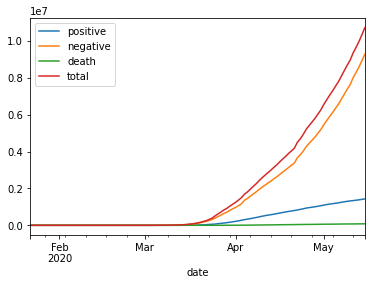

In [13]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [14]:
dfWHO.confirmed


date
2020-03-04        108
2020-03-05        129
2020-03-06        148
2020-03-07        213
2020-03-08        213
               ...   
2020-05-11    1271645
2020-05-12    1298287
2020-05-13    1322054
2020-05-14    1340098
2020-05-15    1361522
Name: confirmed, Length: 73, dtype: int64

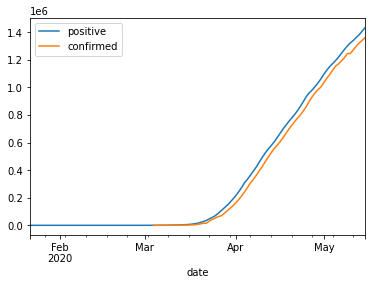

In [15]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [16]:
gbCA.sum()[-8:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-08,62512,812760,0,4514.0,0.0,1342.0,0.0,0.0,0.0,0.0,2585,0.0,875272,875272,875272,81.0,0.0,30500.0,1898.0,32398.0
2020-05-09,64561,848009,0,4538.0,0.0,1349.0,0.0,0.0,0.0,0.0,2678,0.0,912570,912570,912570,93.0,0.0,35249.0,2049.0,37298.0
2020-05-10,66680,888984,0,4555.0,0.0,1328.0,0.0,0.0,0.0,0.0,2745,0.0,955664,955664,955664,67.0,0.0,40975.0,2119.0,43094.0
2020-05-11,67939,923958,0,4549.0,0.0,1329.0,0.0,0.0,0.0,0.0,2770,0.0,991897,991897,991897,25.0,0.0,34974.0,1259.0,36233.0
2020-05-12,69382,963988,0,4544.0,0.0,1349.0,0.0,0.0,0.0,0.0,2847,0.0,1033370,1033370,1033370,77.0,0.0,40030.0,1443.0,41473.0
2020-05-13,71141,994451,0,4545.0,0.0,1314.0,0.0,0.0,0.0,0.0,2934,0.0,1065592,1065592,1065592,87.0,0.0,30463.0,1759.0,32222.0
2020-05-14,73164,1031487,0,4655.0,0.0,1324.0,0.0,0.0,0.0,0.0,3032,0.0,1104651,1104651,1104651,98.0,0.0,37036.0,2023.0,39059.0
2020-05-15,74936,1058970,0,4519.0,0.0,1324.0,0.0,0.0,0.0,0.0,3108,0.0,1133906,1133906,1133906,76.0,0.0,27483.0,1772.0,29255.0


In [17]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1442824
dead           87530
dtype: int64

In [18]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    76693
dead          3136
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [20]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1442824
Russia             262843
United Kingdom     238004
Spain              230183
Italy              223885
Brazil             220291
France             179630
Germany            175233
Turkey             146457
Iran               116635
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [25]:
dfState.loc['FL'].head(7)

,date,positive,death,current_total,pct
state,,,,,
FL,2020-05-15,43210,1991,43210,1.000000
FL,2020-05-14,43210,1948,43210,1.000000
FL,2020-05-13,42402,1898,43210,0.981301
FL,2020-05-12,41923,1849,43210,0.970215
FL,2020-05-11,40982,1805,43210,0.948438
FL,2020-05-10,40596,1791,43210,0.939505
FL,2020-05-09,40001,1785,43210,0.925735


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

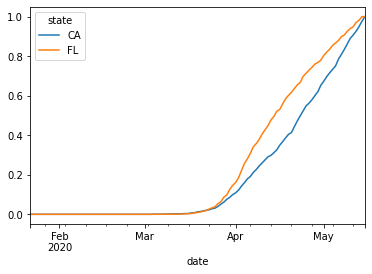

In [27]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

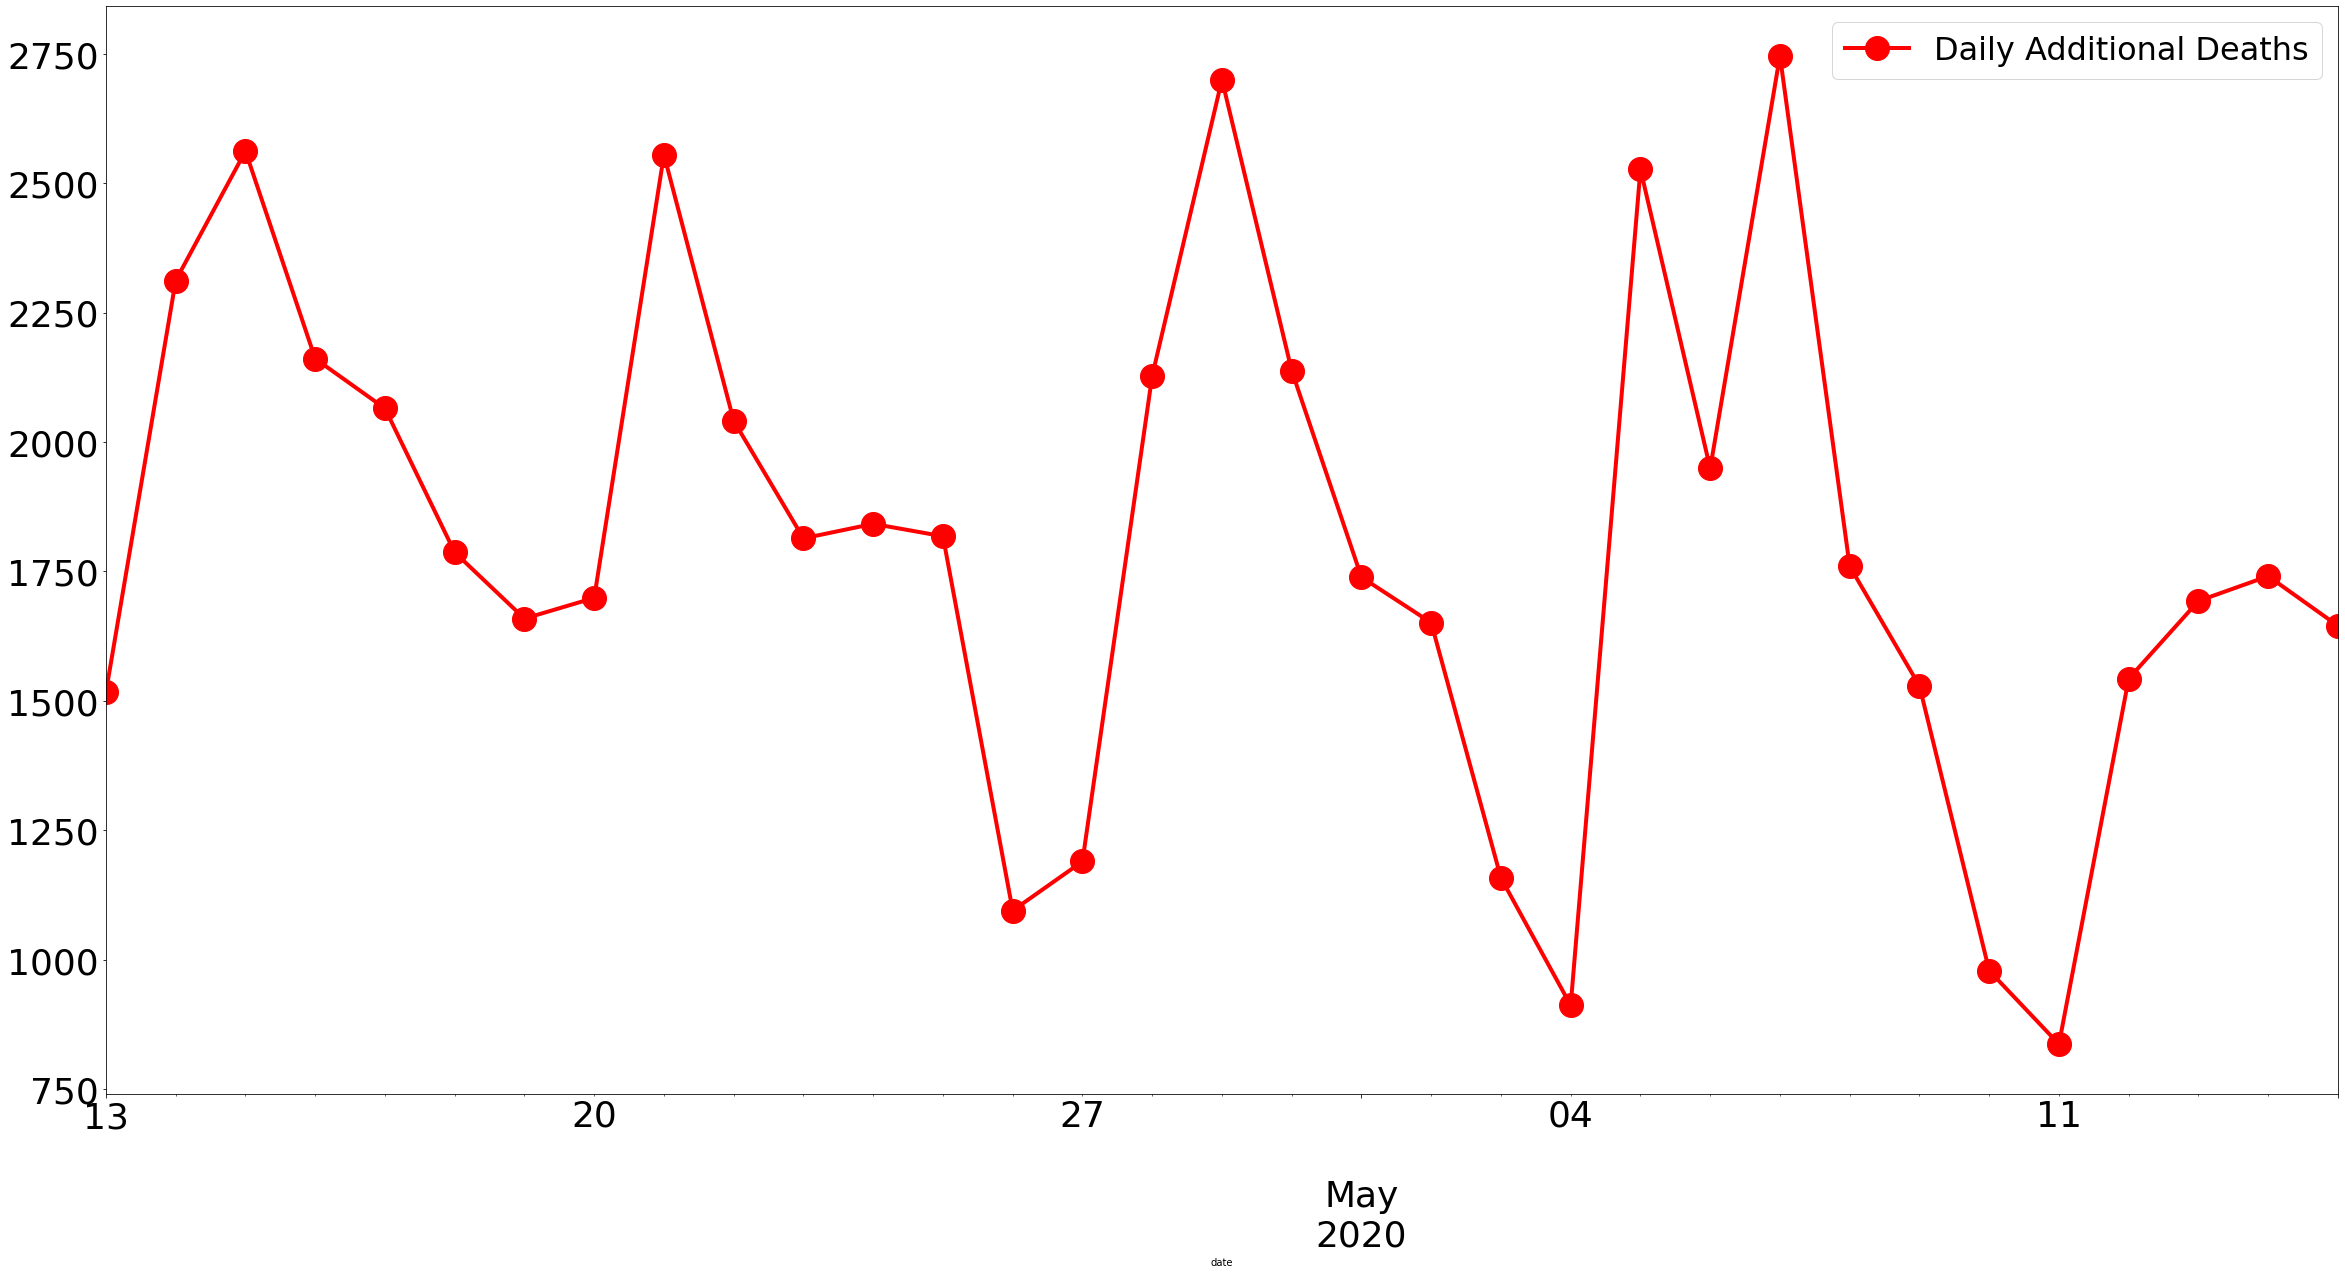

In [29]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


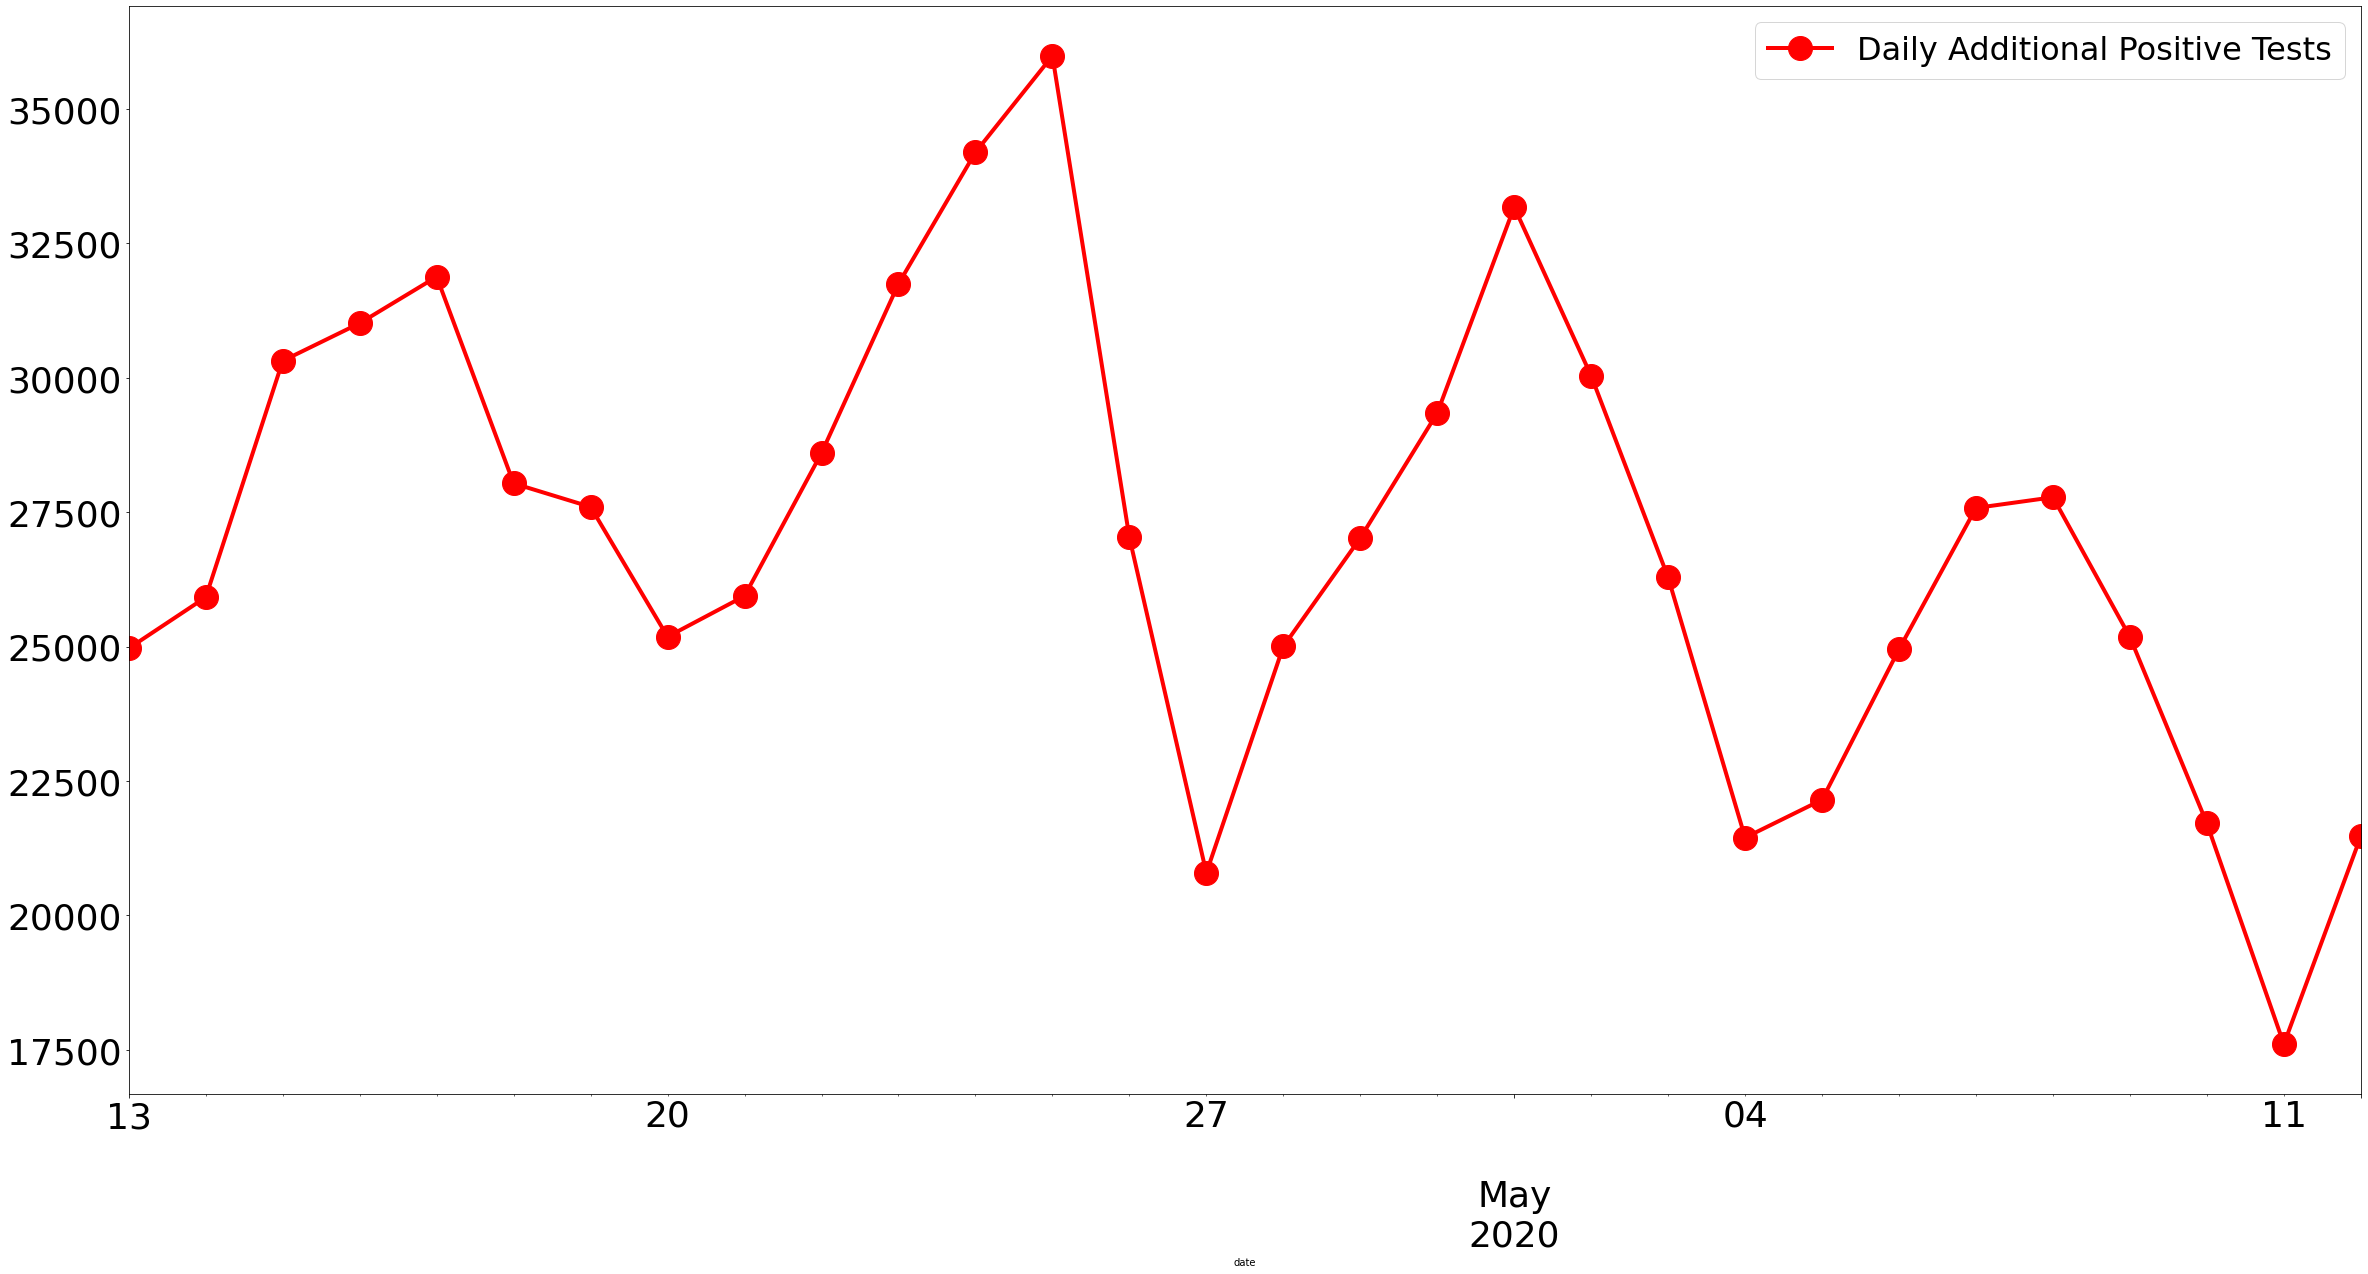

In [30]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:-3].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


In [33]:
dfDoW.sum().deathIncrease



0     8023.0
1    14017.0
2    14050.0
3    13957.0
4    12780.0
5    10592.0
6     8310.0
Name: deathIncrease, dtype: float64

In [34]:
dfByWeekYear.sum()[:-1]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202004,0.0,0.0,0.0,0.0,0.0
202005,0.0,0.0,0.0,0.0,0.0
202006,0.0,0.0,0.0,1.0,1.0
202007,0.0,0.0,0.0,0.0,0.0
202008,0.0,0.0,0.0,0.0,0.0
202009,8.0,0.0,81.0,28.0,109.0
202010,23.0,0.0,2821.0,595.0,3416.0
202011,46.0,0.0,30203.0,4113.0,34316.0
202012,360.0,2498.0,179297.0,31483.0,210780.0
202013,2090.0,13739.0,497952.0,107963.0,605915.0


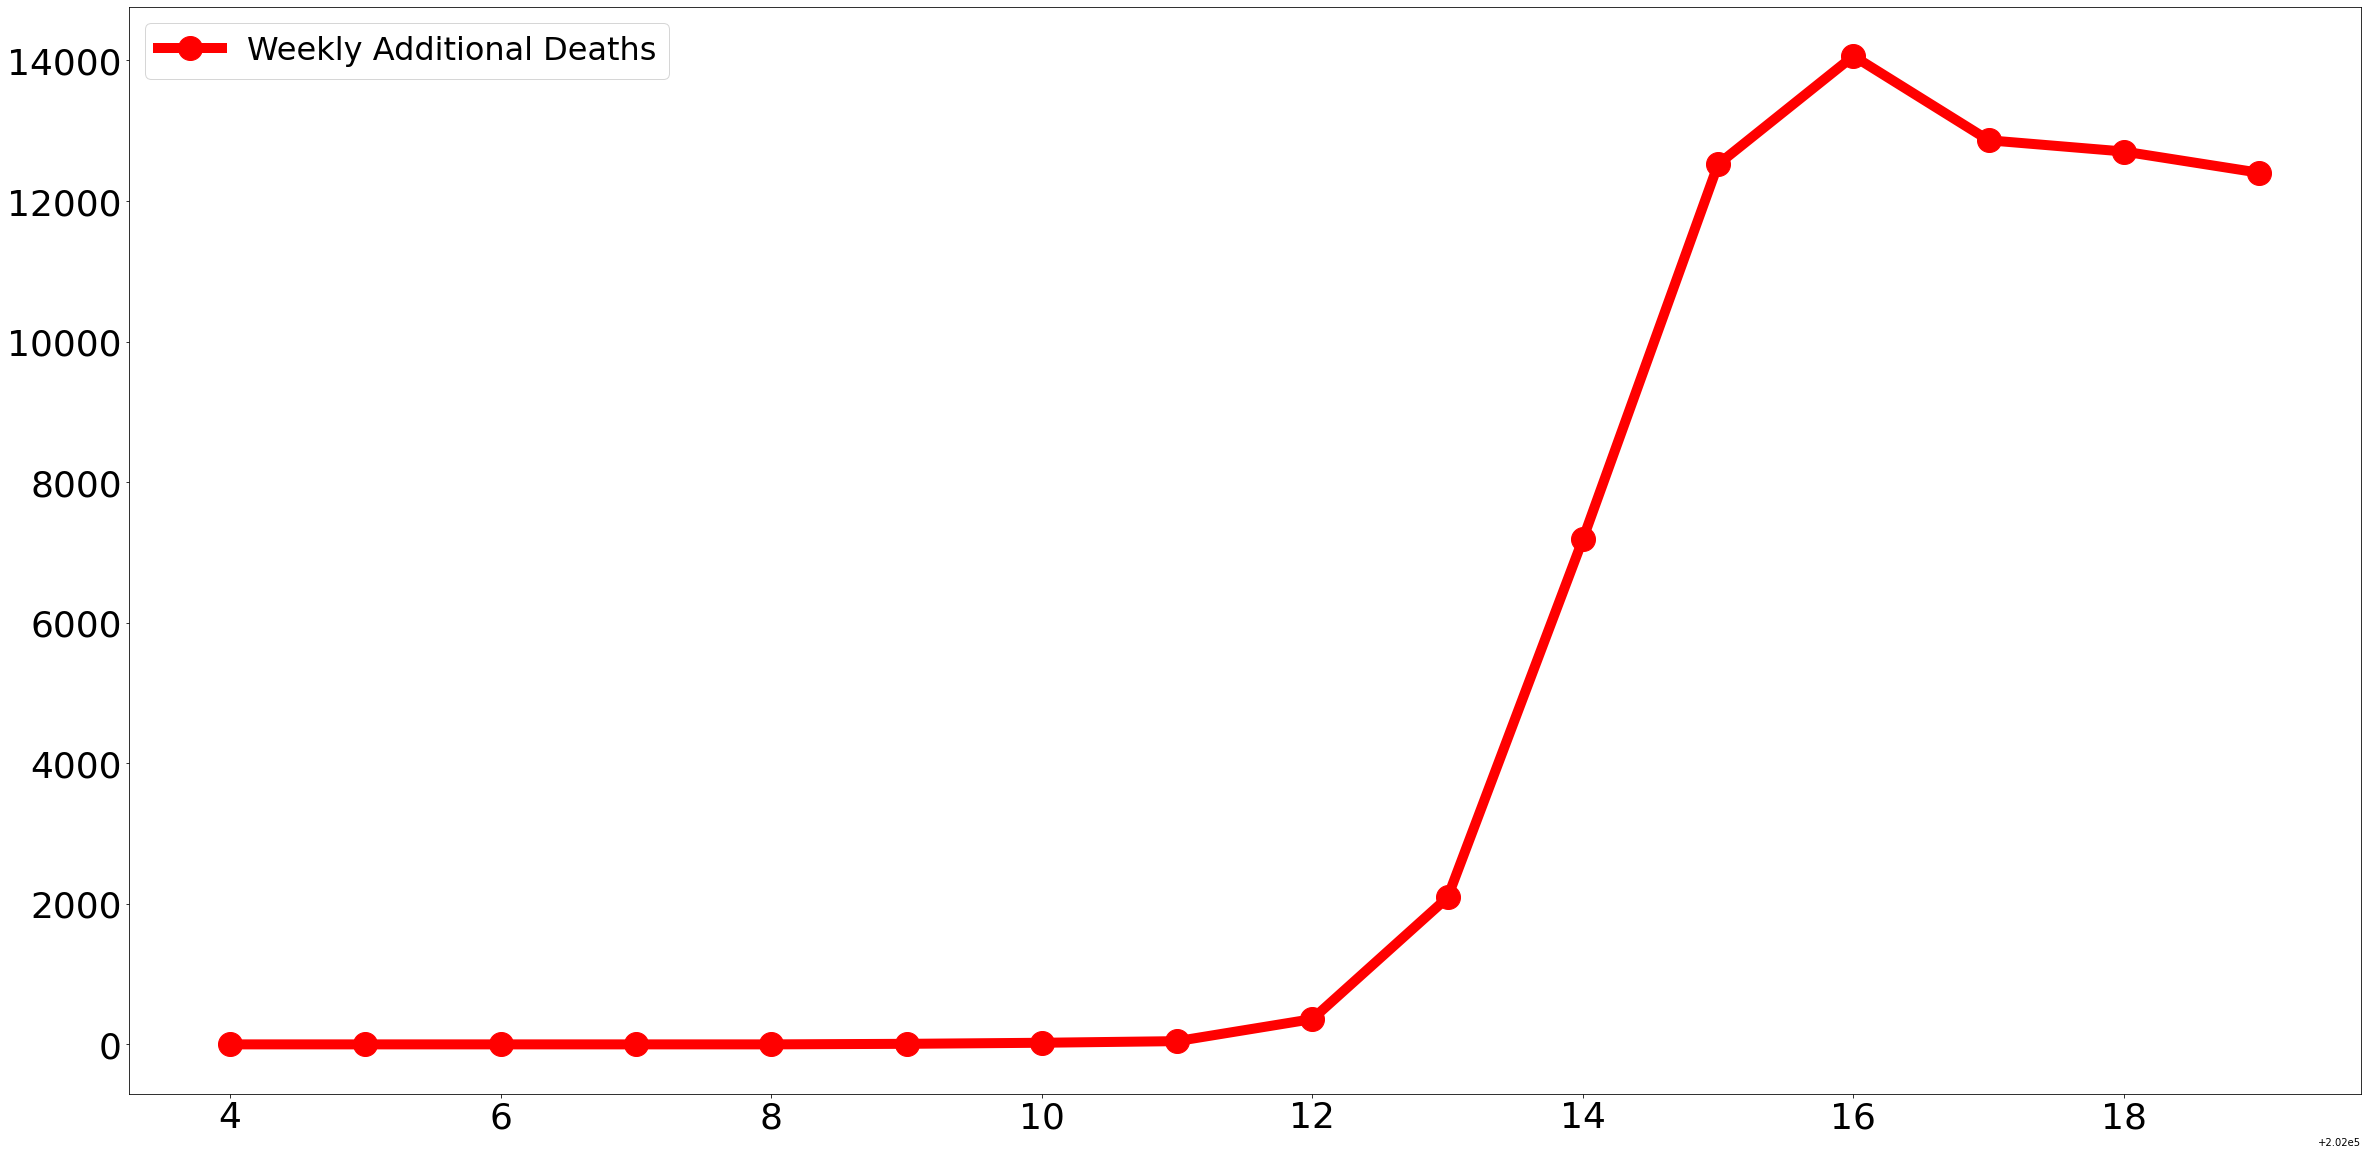

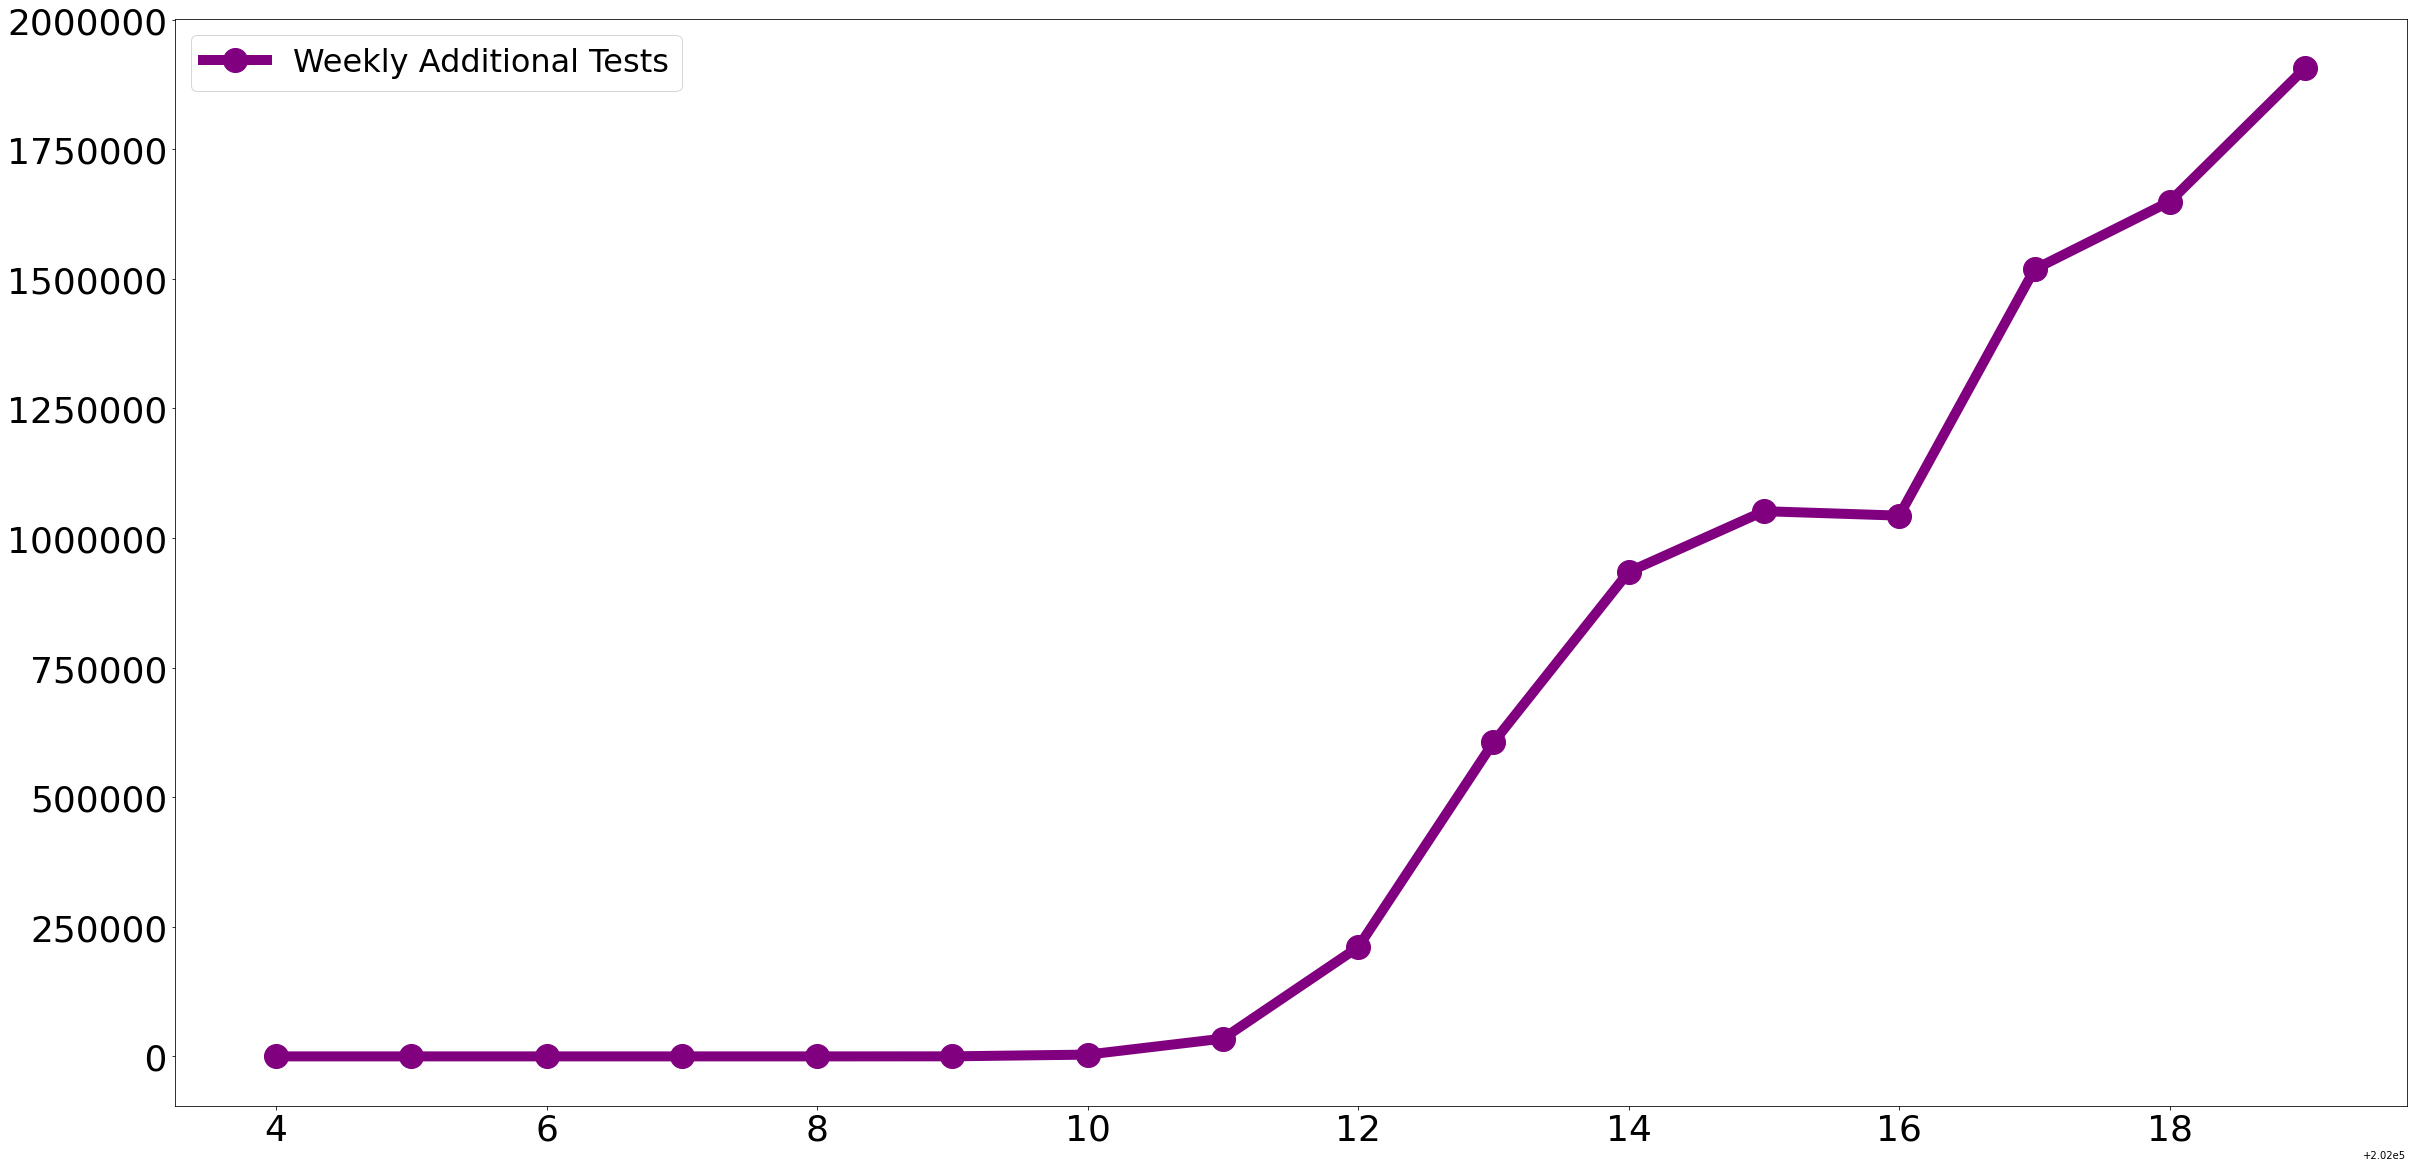

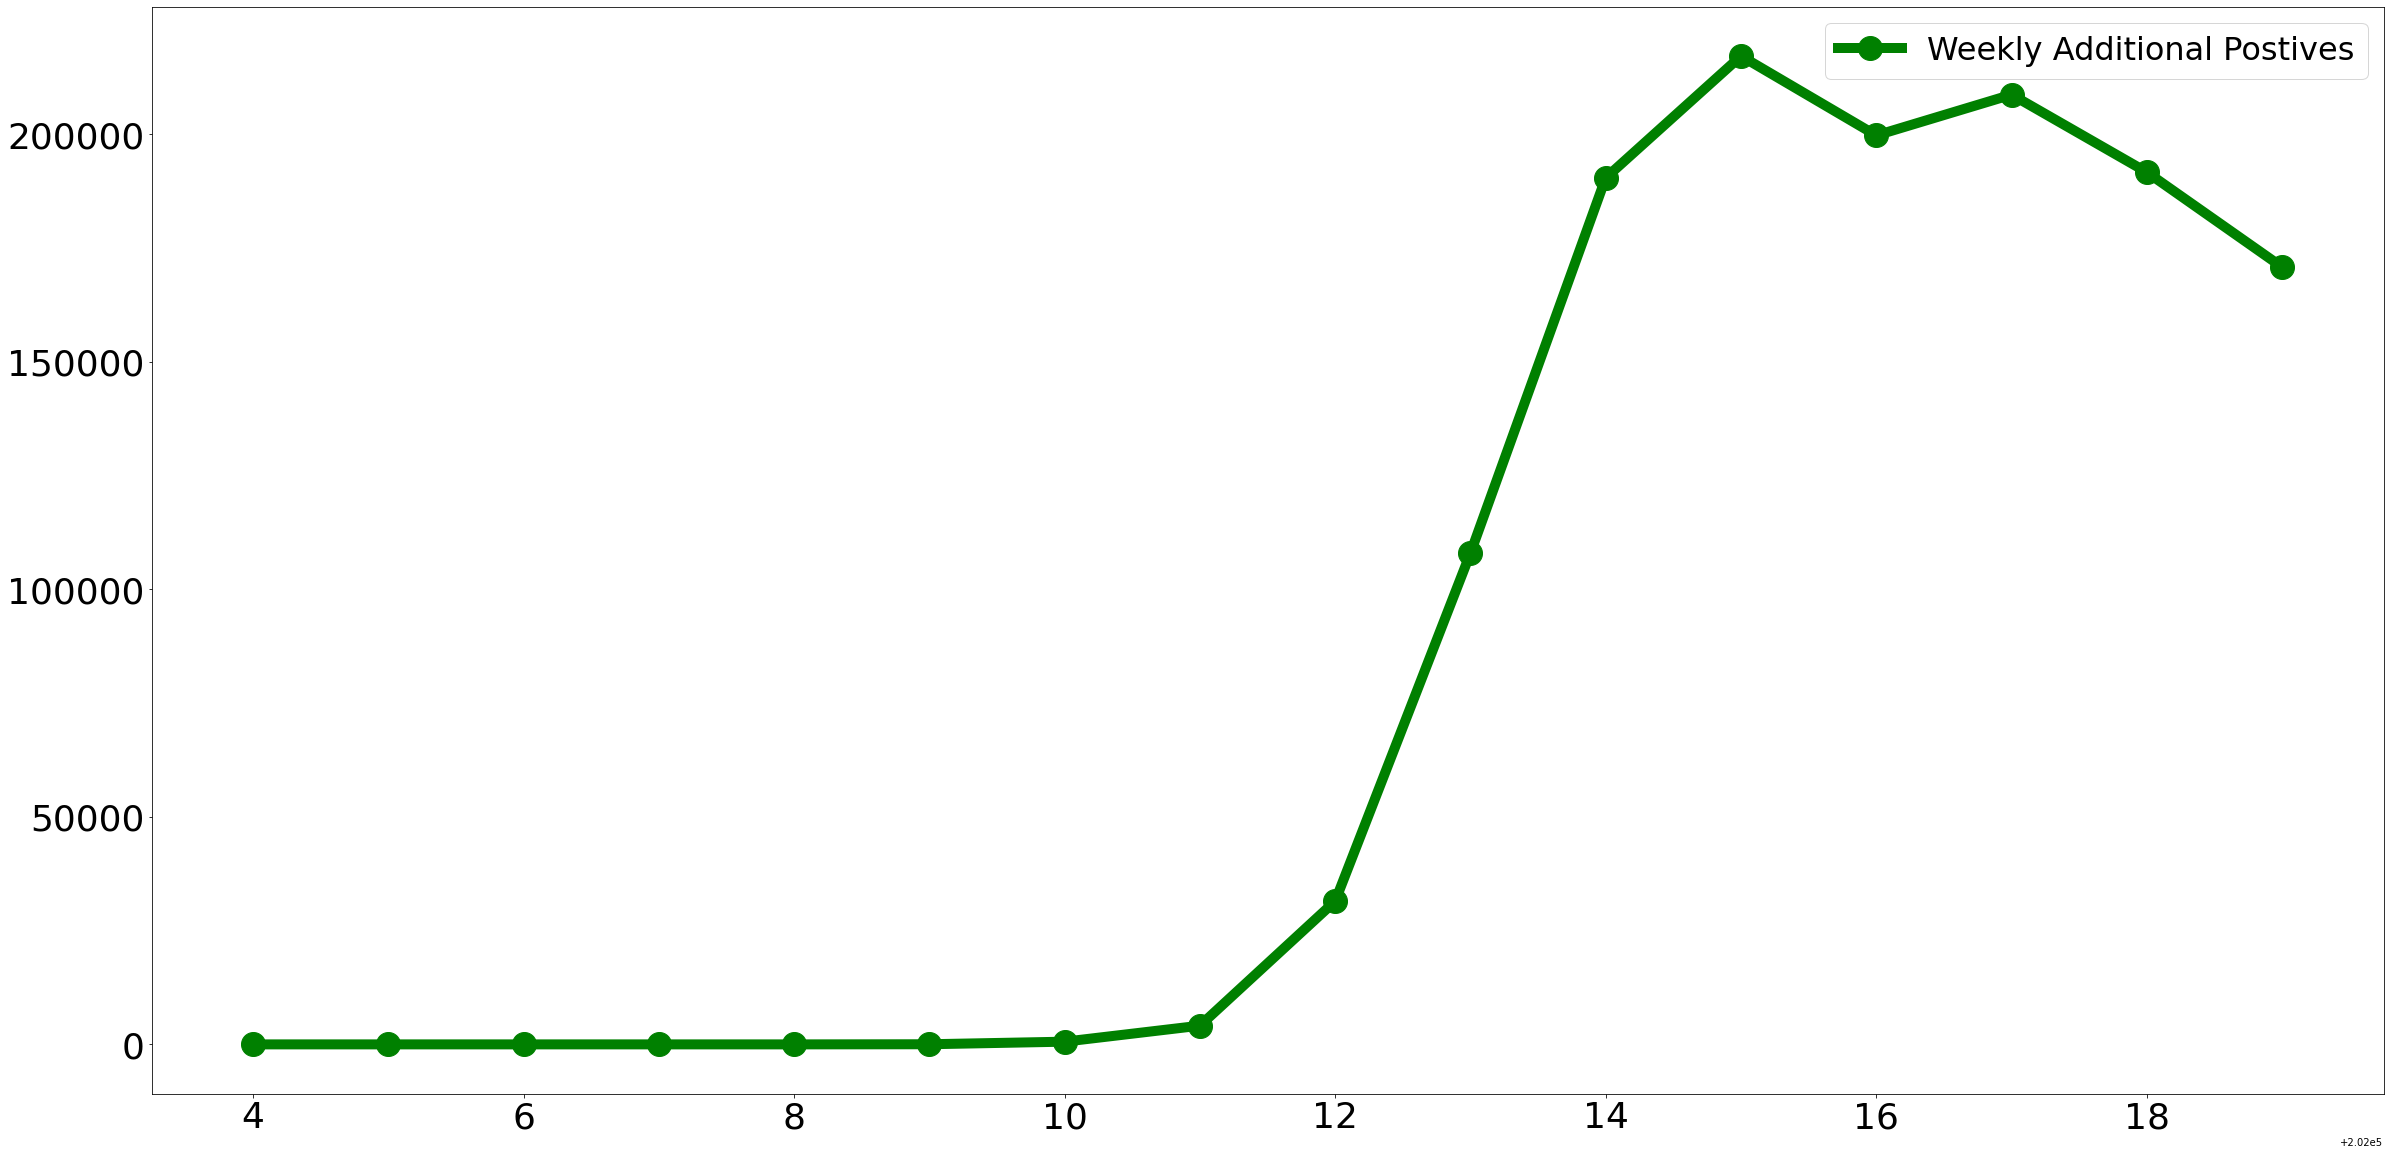

In [35]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

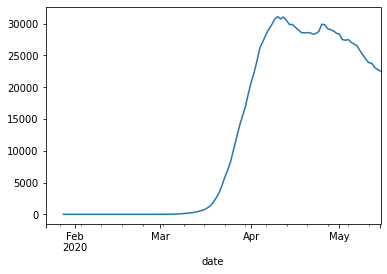

In [36]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

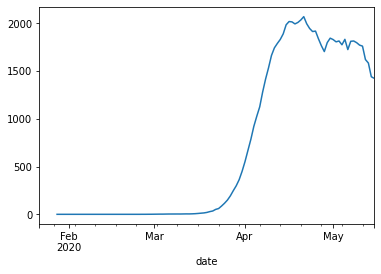

In [37]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

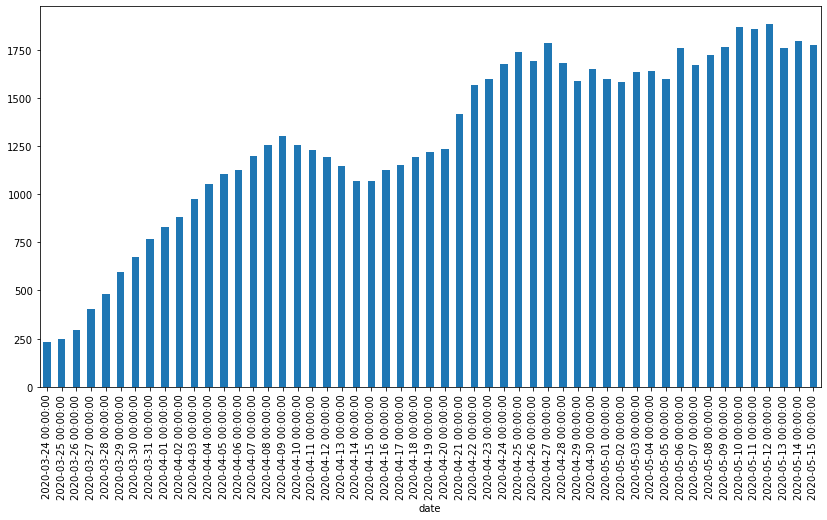

In [39]:

graph1 = dfCAAvg[20:].positiveIncrease.plot.bar(figsize=(14,7))


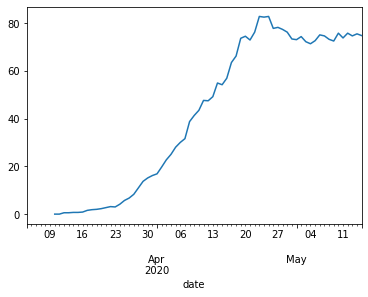

In [40]:
dfCAAvg.deathIncrease.plot.line()

In [41]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,current_total,pct
704,FL,2020-05-15,43210,1991,43210,1.000000
705,FL,2020-05-14,43210,1948,43210,1.000000
706,FL,2020-05-13,42402,1898,43210,0.981301
707,FL,2020-05-12,41923,1849,43210,0.970215
708,FL,2020-05-11,40982,1805,43210,0.948438
709,FL,2020-05-10,40596,1791,43210,0.939505
710,FL,2020-05-09,40001,1785,43210,0.925735
711,FL,2020-05-08,39199,1738,43210,0.907174
712,FL,2020-05-07,38828,1667,43210,0.898588
713,FL,2020-05-06,38002,1605,43210,0.879472


In [83]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .75)].sort_values(by='pct')


,state,date,positive,death,current_total,pct
1768,MN,2020-05-08,10088,534,14240,0.708427


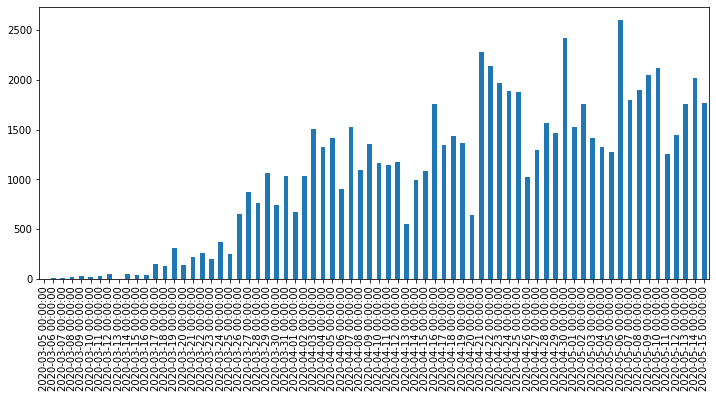

In [43]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar(figsize=(12,5))



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [46]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     1433696
negative     9286489
pending         2457
death          81729
total       10722642
dtype: int64
Current Infection Rate 13.370735%
Percentage of US affected: 0.461683%
Observed CFR: 5.700581%
Percentage of US tested/affected: 3.290863%
Projected affected by cir = 43,888,036
Projected killed = 2,501,873


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [54]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.777633,6.878165
NJ,1.620152,5.212363
MA,1.210315,6.321056
RI,1.153431,9.909559
CT,1.012120,4.372944
DC,0.973576,4.865611
DE,0.757165,3.930932
LA,0.727866,5.446337
IL,0.713149,4.250391


In [55]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 3.265964%


In [56]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [58]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso_code                  17361 non-null  object 
 1   location                  17425 non-null  object 
 2   date                      17425 non-null  object 
 3   total_cases               17425 non-null  int64  
 4   new_cases                 17425 non-null  int64  
 5   total_deaths              17425 non-null  int64  
 6   new_deaths                17425 non-null  int64  
 7   total_cases_per_million   17117 non-null  float64
 8   new_cases_per_million     17117 non-null  float64
 9   total_deaths_per_million  17117 non-null  float64
 10  new_deaths_per_million    17117 non-null  float64
 11  total_tests               4455 non-null   float64
 12  new_tests                 3961 non-null   float64
 13  total_tests_per_thousand  4455 non-null   float64
 14  new_te

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [61]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    9974831.0
RUS    6188102.0
DEU    3147771.0
ITA    2807504.0
IND    1947041.0
         ...    
PRY      14646.0
CRI      12822.0
MMR      12482.0
ZWE      11191.0
BOL       9234.0
Name: total_tests, Length: 84, dtype: float64

In [62]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 36082737
Total tests done in USA : 9974831
How many more times has the world tested more than the US: 3.6


In [63]:
dfOwidLatest[isUSA].sum()

location                                                  United States
date                                                         2020-05-13
total_cases                                                     1369964
new_cases                                                         22048
total_deaths                                                      82387
new_deaths                                                         1703
total_cases_per_million                                         4138.83
new_cases_per_million                                             66.61
total_deaths_per_million                                        248.901
new_deaths_per_million                                            5.145
total_tests                                                 9.97483e+06
new_tests                                                        324426
total_tests_per_thousand                                         30.135
new_tests_per_thousand                                          

In [64]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-14:]

,new_cases,new_deaths
date,,
2020-05-02,33955,2062
2020-05-03,29288,1317
2020-05-04,24972,1297
2020-05-05,22593,1252
2020-05-06,23841,2144
2020-05-07,24128,2353
2020-05-08,28369,2239
2020-05-09,26957,1510
2020-05-10,25612,1614


In [0]:
state = 'MN'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state].set_index('date')\
.rolling(window=7).sum()


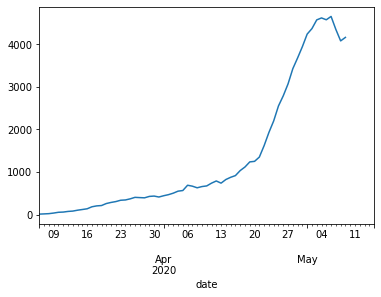

In [66]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [67]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

44138

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'].set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [69]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,244.0,733.0,27260.0,4297.0,31557.0
1,375.0,1333.0,49724.0,6503.0,56227.0
2,291.0,1567.0,32075.0,6331.0,38406.0
3,203.0,901.0,44037.0,5058.0,49095.0
4,266.0,1061.0,57529.0,6785.0,64314.0
5,113.0,631.0,33071.0,3970.0,37041.0
6,65.0,212.0,21497.0,3735.0,25232.0


In [70]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")

In [0]:
results = client.get("tvq9-ec9w")


In [0]:

results_df = pd.DataFrame.from_records(results)

In [0]:
res = results_df.astype({'case_count':'int16'})

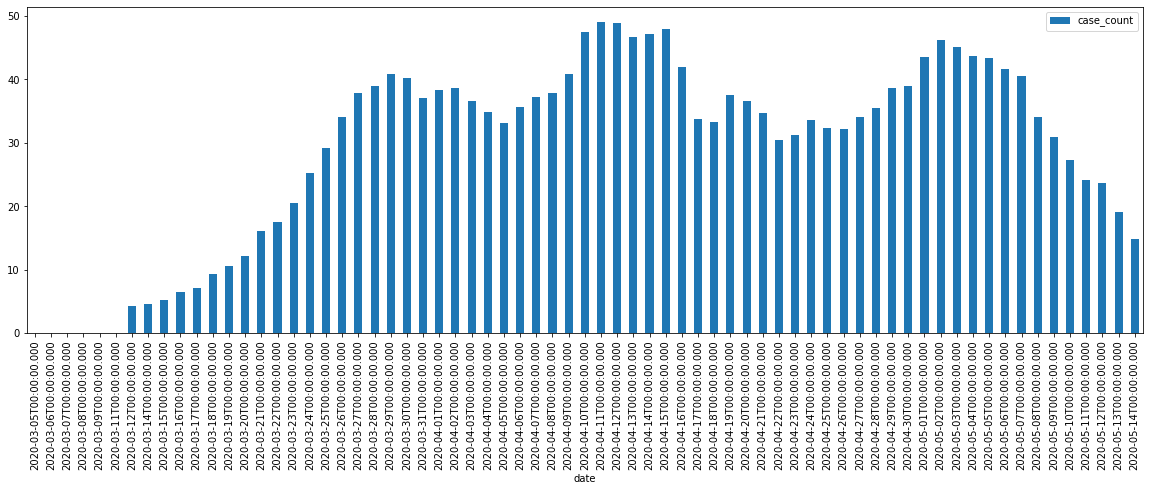

In [76]:
res.groupby('date').sum().rolling(window=7).mean().plot.bar(figsize=(20,6))

In [77]:
res.case_count.max()

36

In [78]:
res.groupby(by='transmission_category').sum().sum()

case_count    2062
dtype: int64

In [79]:
res.groupby(by='case_disposition').sum()

,case_count
case_disposition,
Confirmed,2026
Death,36
